# Energetics analysis for generated structures

## Experiments

We have trained Riemannian score model and the baseline Euclidean score model.

A hundred different molecular structures are generated from corresponding MMFF structure.

We compare the generative performance of the models in persepective of molecular energy.


In [1]:
import ase
import ase.io
import json
import numpy as np
import os.path as osp
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset

base_dir = "/home/share/DATA/QM9M/to_shkim"
index_list = [int(osp.basename(xyz_file)[3:-4]) for xyz_file in glob.glob(osp.join(base_dir, "baseline_xyz/*.xyz"))]

baseline_data = []
for idx in index_list:
    xyz_file = osp.join(base_dir, f"baseline_xyz/idx{idx}.xyz")
    atoms = ase.io.read(xyz_file)
    data = atoms.info

    json_file = osp.join(base_dir, f"baseline_xyz/results/idx{idx}/input.json")
    with open(json_file, "r") as f:
        json_data = json.load(f)
    energy = json_data["optimization"]["scf"]["scf energies"][0]
    data["gen_energy"] = energy
    
    # load referece energy
    reference_file = f"/home/share/DATA/QM9M/sdf_files/{idx}.sdf"
    with open(reference_file, "r") as f:
        lines = f.readlines()
    reference_prop = [float(v) for v in lines[0].split()]
    energy = (reference_prop[-5] - reference_prop[-6])
    data["ref_energy"] = energy

    baseline_data.append(data)

morse_data = []
for idx in index_list:
    xyz_file = osp.join(base_dir, f"morse_xyz/idx{idx}.xyz")
    atoms = ase.io.read(xyz_file)
    data = atoms.info
    
    json_file = osp.join(base_dir, f"morse_xyz/results/idx{idx}/input.json")
    with open(json_file, "r") as f:
        json_data = json.load(f)
    energy = json_data["optimization"]["scf"]["scf energies"][0]
    data["gen_energy"] = energy

    # load referece energy
    reference_file = f"/home/share/DATA/QM9M/sdf_files/{idx}.sdf"
    with open(reference_file, "r") as f:
        lines = f.readlines()
    reference_prop = [float(v) for v in lines[0].split()]
    energy = (reference_prop[-5] - reference_prop[-6])
    data["ref_energy"] = energy

    morse_data.append(data)

In [3]:
baseline_df = pd.DataFrame(baseline_data)
morse_df = pd.DataFrame(morse_data)

Riemannian Score Model


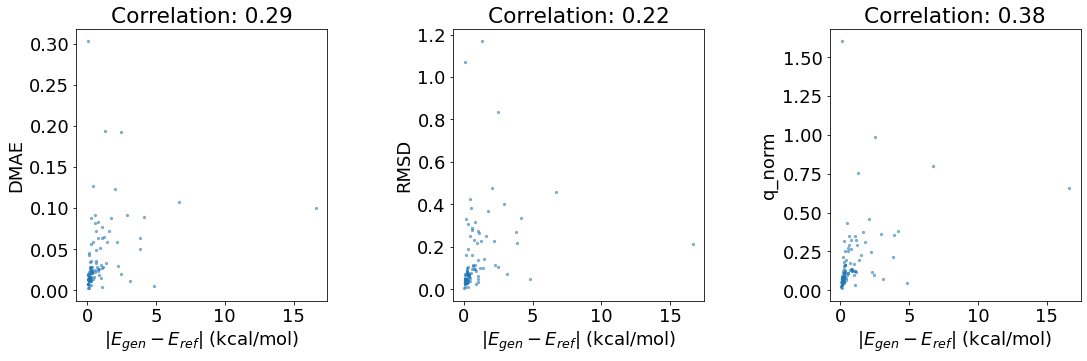

Baseline Model


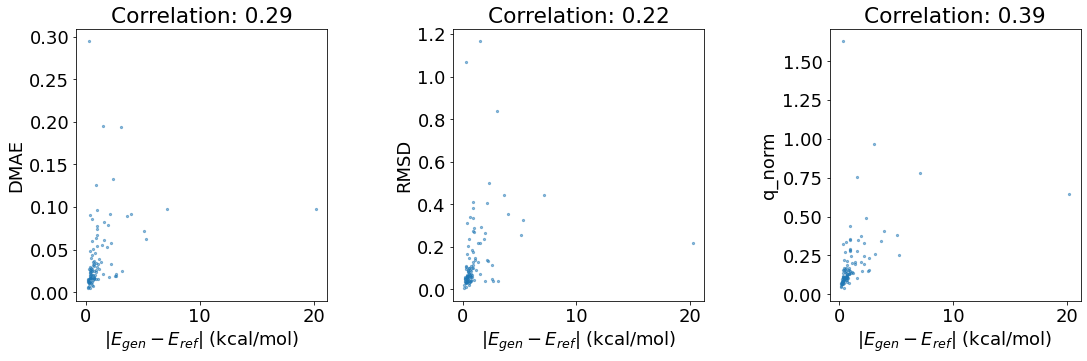

In [4]:
def draw_fig(df):
    q_norm = df.q_norm.to_numpy()
    dmae = df.dmae.to_numpy()
    rmsd = df.rmsd.to_numpy()

    eV2kcalmol = 23.0609
    e_diff = (df.gen_energy.to_numpy() - df.ref_energy.to_numpy()) * eV2kcalmol
    abs_e_diff = np.abs(e_diff)

    # plot q_norm vs abs_e_diff, dmae vs abs_e_diff, rmsd vs abs_e_diff
    fig = plt.figure(figsize=(18, 5))

    # adjust the space between the plots
    fig.subplots_adjust(wspace=0.5)
    plt.rcParams.update({'font.size': 18})

    axes = fig.subplots(1, 3)
    for ax, y, y_label in zip(axes, [dmae, rmsd, q_norm], ["DMAE", "RMSD", "q_norm"]):
        ax.scatter(abs_e_diff, y, s=5, alpha=0.5)
        ax.set_xlabel("$\\vert E_{gen} - E_{ref} \\vert$ (kcal/mol)")
        ax.set_ylabel(y_label)
        # kde plot
        # sns.kdeplot(abs_e_diff, y, ax=ax, cmap="viridis", shade=False, shade_lowest=False, alpha=0.2)
        # pearson correlation
        corr = np.corrcoef(abs_e_diff, y)[0, 1]
        ax.set_title(f"Correlation: {corr:.2f}")
    
    plt.show()

df = morse_df
print("Riemannian Score Model")
draw_fig(df)

df = baseline_df
print("Baseline Model")
draw_fig(df)

Riemannian Score Model
     name      mean        Q1        Q2        Q3
0    DMAE  0.040059  0.014584  0.023755  0.052960
1    RMSD  0.149167  0.042716  0.074198  0.215619
2  q_norm  0.184916  0.073525  0.115362  0.217204
3  Energy  0.972035  0.189234  0.336537  1.021808
Euclidean Score Model
     name      mean        Q1        Q2        Q3
0    DMAE  0.042000  0.016533  0.025750  0.054332
1    RMSD  0.156648  0.048652  0.086608  0.206225
2  q_norm  0.207251  0.101882  0.140973  0.244566
3  Energy  1.258191  0.391514  0.663143  1.121866


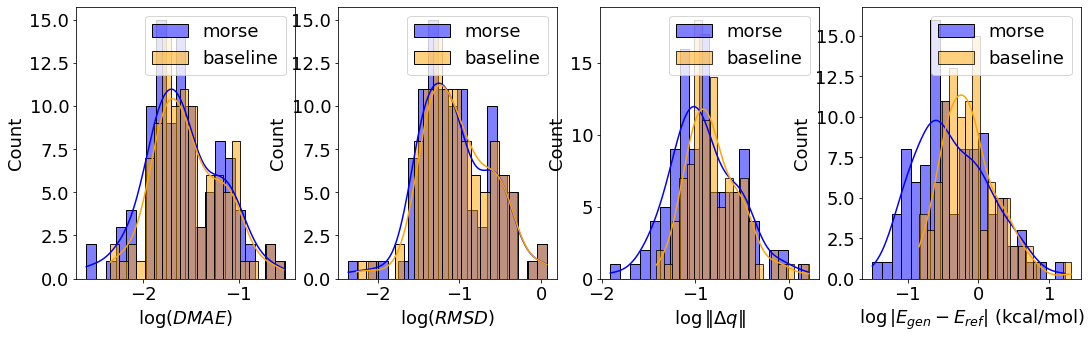

In [5]:
eV2kcalmol = 23.0609

# plot kde plot and hist
fig = plt.figure(figsize=(18, 5))
axes = fig.subplots(1, 4)

df = morse_df
q_norm = df.q_norm.to_numpy()
dmae = df.dmae.to_numpy()
rmsd = df.rmsd.to_numpy()
e_diff = (df.gen_energy.to_numpy() - df.ref_energy.to_numpy()) * eV2kcalmol
abs_e_diff = np.abs(e_diff)
morse_stats = []
for ax, y, y_label in zip(axes, [dmae, rmsd, q_norm, abs_e_diff], ["DMAE", "RMSD", "q_norm", "Energy"]):
    stat = {"name": y_label, "mean": np.mean(y), "Q1": np.percentile(y, 25), "Q2": np.median(y), "Q3": np.percentile(y, 75)}
    morse_stats.append(stat)
    y = np.log10(y + 1e-10)
    sns.histplot(y, ax=ax, kde=True, alpha=0.5, color="blue", label="morse", bins=20)
    
df = baseline_df
q_norm = df.q_norm.to_numpy()
dmae = df.dmae.to_numpy()
rmsd = df.rmsd.to_numpy()
e_diff = (df.gen_energy.to_numpy() - df.ref_energy.to_numpy()) * eV2kcalmol
abs_e_diff = np.abs(e_diff)
baseline_stats = []
for ax, y, y_label in zip(axes, [dmae, rmsd, q_norm, abs_e_diff], ["DMAE", "RMSD", "q_norm", "Energy"]):
    stat = {"name": y_label, "mean": np.mean(y), "Q1": np.percentile(y, 25), "Q2": np.median(y), "Q3": np.percentile(y, 75)}
    baseline_stats.append(stat)
    y = np.log10(y + 1e-10)
    sns.histplot(y, ax=ax, kde=True, alpha=0.5, color="orange", label="baseline", bins=20)

for ax, y_label in zip(axes, ["$\\log (DMAE)$", "$\\log (RMSD)$", "$\\log \\Vert \\Delta q \\Vert$", "$\\log \\vert E_{gen} - E_{ref} \\vert$ (kcal/mol)"]):
    ax.set_xlabel(y_label)
    ax.legend()
# print stats as table form
morse_stats_df = pd.DataFrame(morse_stats)
baseline_stats_df = pd.DataFrame(baseline_stats)
print("Riemannian Score Model")
print(morse_stats_df)
print("Euclidean Score Model")
print(baseline_stats_df)